In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt 
from numpy.linalg import eig
import matplotlib.animation as animation
from IPython.display import clear_output

# General Parameters
mass_electron = 9.109534e-31 # 1.0 # [kg]
hbar = 6.582119569e-16 # [eV s] source: wikipedia
# length = 100.0 # [??]
number_steps = 500
electric_field = 0.0# 5 #0.01 # Electric field [V/nm]
electron_charge = 1 # 1.60217663e-19 # [C]

In [208]:
# plotting
PLOT_LIMIT = []#400,800]
Y_LIMIT = [] # leave blank for auto
ERROR_BARS = False
PLOT_FITTED = False
split_ = ","
LABEL_FONT_SIZE = 13
TICK_FONT_SIZE = 11
LINE_WIDTH = 0.5
LEGEND = True
label_x = ""
label_y = ""
plot_title = ""
aspect_ratio = [9,9]

colours = [ 'black', 'dimgrey', 'lightslategrey', 'lightsteelblue', 'silver', 'cadetblue', 'darkcyan', 'teal', 'darkslategray', 'seagreen', 'mediumseagreen', 'darkolivegreen', 'olivedrab', 'olive', 'yellowgreen', 'green', 'springgreen', 'mediumspringgreen', 'turquoise', 'lightseagreen']

def plot_graph(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (aspect_ratio[0],aspect_ratio[1])
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize = TICK_FONT_SIZE)
    plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    plt.plot(x, y, linewidth = LINE_WIDTH, color = 'dimgrey', marker = 's', markersize = 0.5, markerfacecolor='dimgrey')
    plt.grid(True, alpha=0.2)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()

def plot_graphs(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (6,6)
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #plt.xticks(fontsize = TICK_FONT_SIZE)
    #plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    i=0
    for ys in y:
        if i < len(colours):
            plt.plot(x, ys, linewidth = LINE_WIDTH, marker = 's', markersize = 0.5, color = colours[i])
        else:
            plt.plot(x, ys, linewidth = LINE_WIDTH, marker = 's', markersize = 0.5)
        i+=1
    plt.grid(True, alpha=0.2)
    if(LEGEND==True):
        plt.legend(legend)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()

def make_array(y, number_steps):
    p = np.zeros(number_steps)
    for nr in range(0, number_steps):
        p[nr] = y
    return p

In [147]:
# voigt function details
num_discrete = 2048
func_x = np.zeros(num_discrete)
Gauss_y = np.zeros(num_discrete)
Lorentz_y = np.zeros(num_discrete)
x_0 = num_discrete/2
gamma = 50
sigma = gamma
PLOT_LIMIT=[]

def pad_func_zeros(func):
    func_new = np.zeros(2*len(func))
    j = 0
    for i in range(int(0.25*len(func_new)), int(0.75*len(func_new))):
        func_new[i] = func[j]
        j+=1
    return func_new # twice in length

def pad_func_linear(func):
    func_new = np.zeros(2*len(func))
    j = 0
    del_f = np.abs(func[1]-func[2])
    for i in range(0, int(0.25*len(func_new))):
        func_new[i] = func[0]-0.5*(func[len(func)-1]-func[0]) + i*del_f
    for i in range(int(0.25*len(func_new)), int(0.75*len(func_new))):
        func_new[i] = func[j]
        j+=1
    w=j-1
    j=1
    for i in range(int(0.75*len(func_new)), len(func_new)):
        func_new[i] = func[w] + j*del_f
        j+=1
    return func_new # twice in length

def pad_E(f):
    del_f = np.max(f)/(num_discrete-1)
    func_new = np.zeros(2*len(f))
    j = 0
    for i in range(len(func_new)):
        func_new[i] = del_f*i
    return func_new # twice in length

def convolve(f, g): # PAD ARRAYS BEFORE USE FRO ABSORPTION
    FFT_f = np.fft.fft(f)
    FFT_g = np.fft.fft(g)
    FG = FFT_f * FFT_g
    result = np.fft.ifft(FG)
    return np.real(result)

In [148]:
def read_data(file_name):
    data = []
    with open(file_name, 'r') as file:
        sub_data = []
        for line in file:
            if line.strip():  # Non-empty line
                numbers = [float(num) for num in line.split()]
                sub_data.append(numbers)
            else:  # Empty line indicates end of sub-data
                if sub_data:  # Append only if sub_data is not empty
                    data.append(sub_data)
                    sub_data = []  # Reset sub_data
        if sub_data:  # Append the last sub_data
            data.append(sub_data)
    return data

voigt half width: 11.529066927209897


<Figure size 600x600 with 0 Axes>

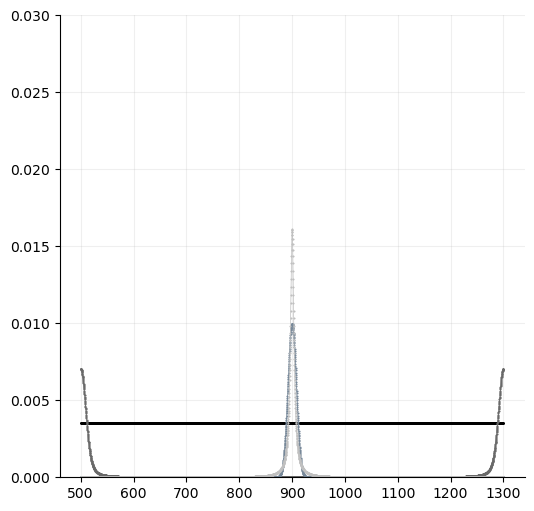

In [153]:
data = []
legend = []

num_discrete = 2048 # Base 2 for FFT
func_x = np.zeros(num_discrete)
Gauss_y = np.zeros(num_discrete)
Lorentz_y = np.zeros(num_discrete)
x_0 = num_discrete/2
gamma = 40

WL_range=[700,1100]
PLOT_LIMIT=WL_range
delta_WL = (WL_range[1]-WL_range[0]) / (num_discrete-1)
epsilon = delta_WL*0.5
sigma = gamma

for i in range(num_discrete):
    func_x[i] = i
    Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
    Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

Gauss_y = Gauss_y/abs(sum(Gauss_y))
Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
func_x_new = pad_func_linear(func_x)
WL_xaxis = np.zeros(num_discrete)
for i in range(num_discrete):
    WL_xaxis[i] = WL_range[0]+i*delta_WL
WL_axis_new = pad_func_linear(WL_xaxis) # for plotting
Lorentz_y_new = pad_func_zeros(Lorentz_y)
Gauss_y_new = pad_func_zeros(Gauss_y)
voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
N_V = abs(sum(voigt_y))
#voigt_y = voigt_y


target_value = max(voigt_y)/2
closest_value = np.unravel_index(np.argmin(np.abs(voigt_y - target_value), axis=None), voigt_y.shape)
print("voigt half width: " + str(abs(WL_axis_new[0]-WL_axis_new[closest_value])))


PLOT_LIMIT=[]
LEGEND=False
label_x = ""
label_y = ""
plot_title = ""
plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])

<Figure size 400x400 with 0 Axes>

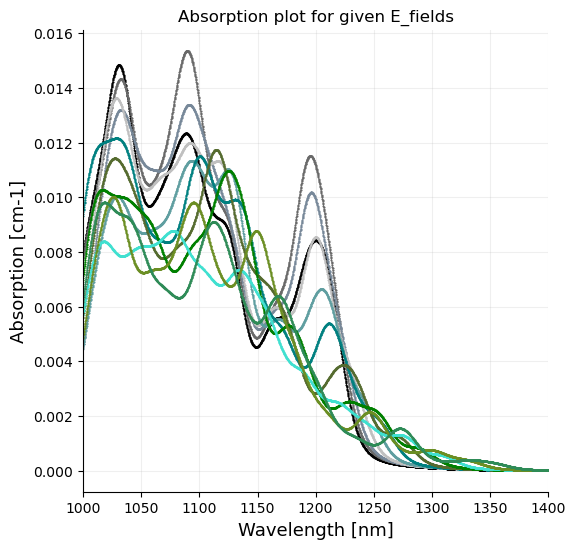

<Figure size 600x600 with 0 Axes>

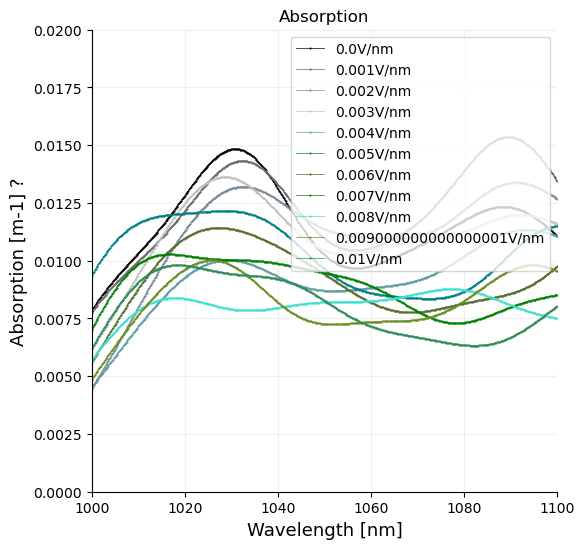

In [195]:
data = []
legend = []

num_discrete = 2048 # Base 2 for FFT
func_x = np.zeros(num_discrete)
Gauss_y = np.zeros(num_discrete)
Lorentz_y = np.zeros(num_discrete)
x_0 = num_discrete/2
gamma = 55

WL_range=[1000,1400]
PLOT_LIMIT=WL_range
delta_WL = (WL_range[1]-WL_range[0]) / (num_discrete-1)
epsilon = delta_WL*0.5
sigma = gamma

for i in range(num_discrete):
    func_x[i] = i
    Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
    Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

Gauss_y = Gauss_y/abs(sum(Gauss_y))
Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
func_x_new = pad_func_linear(func_x)
WL_xaxis = np.zeros(num_discrete)
for i in range(num_discrete):
    WL_xaxis[i] = WL_range[0]+i*delta_WL
WL_axis_new = pad_func_linear(WL_xaxis) # for plotting
Lorentz_y_new = pad_func_zeros(Lorentz_y)
Gauss_y_new = pad_func_zeros(Gauss_y)
voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
N_V = abs(sum(voigt_y))
#voigt_y = voigt_y


target_value = max(voigt_y)/2
closest_value = np.unravel_index(np.argmin(np.abs(voigt_y - target_value), axis=None), voigt_y.shape)
print("voigt half width: " + str(abs(WL_axis_new[0]-WL_axis_new[closest_value])))


PLOT_LIMIT=[]
Y_LIMIT = []
LEGEND=False
label_x = ""
label_y = ""
plot_title = ""
plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])




# ----------------------------------

number_runs = 11
delta_field = 0.001

# ----------------------------------


print("Starting..")
Y_LIMIT = []
for i in range(number_runs):
    print("Analysing file: "+str(i+1)+" / "+str(number_runs))
    electric_field = i*delta_field
    I_squared_matrix_data = read_data("I_squared_matrix_"+str(i)+".txt")
    E_GAP_WL_data = read_data("E_GAP_WL_"+str(i)+".txt")
    I_squared_matrix_data = np.array(I_squared_matrix_data)
    E_GAP_WL_data = np.array(E_GAP_WL_data)

    absorption_yaxis = np.zeros(num_discrete)

    count = 0
    for i in range(num_discrete):
        target_value = WL_xaxis[i]
        closest_value = np.unravel_index(np.argmin(np.abs(E_GAP_WL_data - target_value), axis=None), E_GAP_WL_data.shape)
        prox_check = E_GAP_WL_data[closest_value[0]][closest_value[1]][closest_value[2]]
        if(prox_check < target_value+epsilon and prox_check > target_value-epsilon):
            absorption_yaxis[i] = I_squared_matrix_data[closest_value[0]][closest_value[1]][closest_value[2]]
            count += 1
            
    label_x = "Wavelength [nm]"
    label_y = "Overlap Integral [AU]"
    plot_title = "Current delta space"

    absorption_yaxis_new = pad_func_zeros(absorption_yaxis)     
    absorption = convolve(absorption_yaxis_new,voigt_y)
    data.append(absorption)
    clear_output(wait=True)
    aspect_ratio=[4,4]
    plot_graph(WL_axis_new, absorption_yaxis_new)
    legend.append(str(electric_field) + "V/nm")
    
clear_output(wait=True)

PLOT_LIMIT=WL_range
Y_LIMIT = []
label_x = "Wavelength [nm]"
label_y = "Absorption [cm-1]"
plot_title = "Absorption plot for given E_fields"
plot_graphs(WL_axis_new, data)

PLOT_LIMIT=[1000,1100]
Y_LIMIT = [0,0.02]
label_x = "Wavelength [nm]"
label_y = "Absorption [m-1] ?"
plot_title = "Absorption"
LEGEND=True
plot_graphs(WL_axis_new, data)

<Figure size 600x600 with 0 Axes>

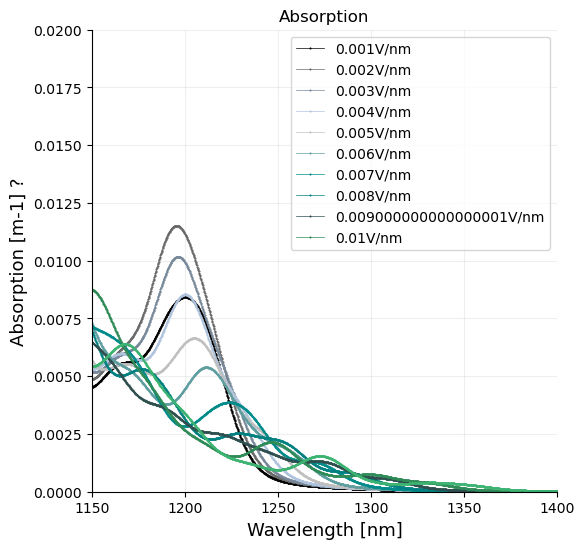

In [212]:
PLOT_LIMIT=[1150,1400]
Y_LIMIT = [0,0.02]
label_x = "Wavelength [nm]"
label_y = "Absorption [m-1] ?"
plot_title = "Absorption"
LEGEND=True
plot_graphs(WL_axis_new, data[0:11])

C:\Users\jmcc0\AppData\Local\Temp\ipykernel_14036\3216263192.py:9: RuntimeWarning: invalid value encountered in double_scalars
  FOM[k][j] = ( data[0][j]  / data[k+1][j] ) - 1
C:\Users\jmcc0\AppData\Local\Temp\ipykernel_14036\3216263192.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  FOM[k][j] = ( data[0][j]  / data[k+1][j] ) - 1


<Figure size 600x600 with 0 Axes>

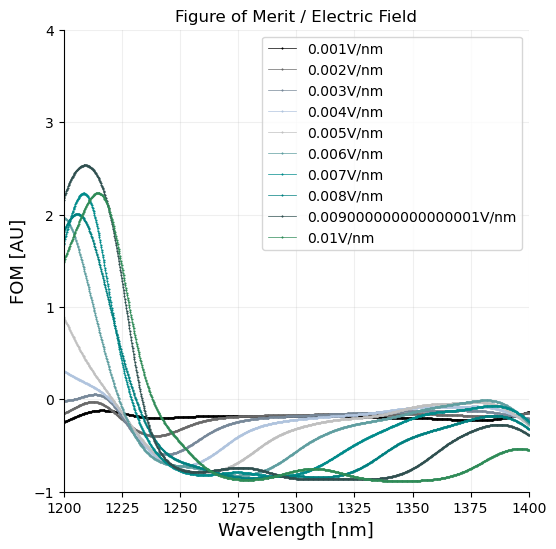

In [210]:
# Figure of Merit Plots ::

legend=[]
FOM = np.zeros((len(data)-1,len(data[0])))
for k in range(len(data)-1):
    electric_field = (k+1)*0.001
    legend.append(str(electric_field) + "V/nm")
    for j in range(len(data[0])):
        FOM[k][j] = ( data[0][j]  / data[k+1][j] ) - 1
        
        
LEGEND=True
label_x = "Wavelength [nm]"
label_y = "FOM [AU]"
plot_title = "Figure of Merit / Electric Field"
Y_LIMIT=[-1,4]

plot_graphs(WL_axis_new, FOM)